In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (에러 시 생략 가능)
plt.rcParams['font.family'] = 'Pretendard'
plt.rcParams['axes.unicode_minus'] = False

In [18]:
# 데이터 로드
df = pd.read_csv("../00.data/telco.csv")
df['ChurnBinary'] = df['Churn Label'].map({'Yes': 1, 'No': 0})

### 1. Acquisition (유입 분석)

C:\Users\somee\AppData\Local\Temp\ipykernel_5112\4118952662.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='JoinYearMonth', y='churn_rate', data=recent_cohort, palette='crest')


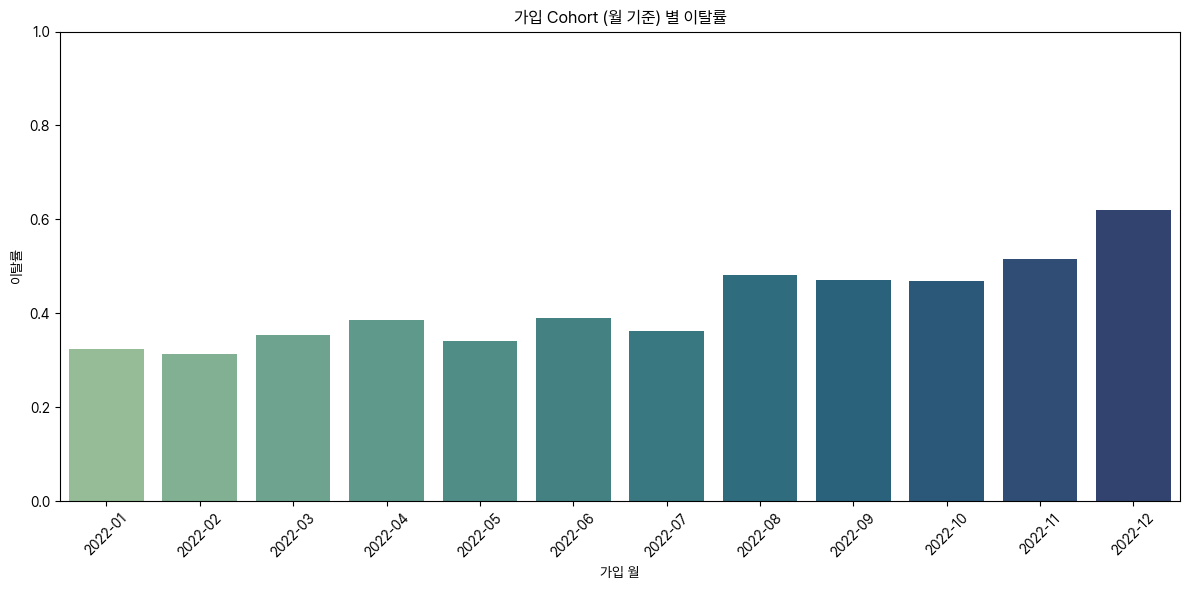

,JoinYearMonth,customers,churned,churn_rate
70,2022-12,613,380,0.619902
69,2022-11,238,123,0.516807
66,2022-08,133,64,0.481203
67,2022-09,176,83,0.471591
68,2022-10,200,94,0.470000
64,2022-06,131,51,0.389313
62,2022-04,119,46,0.386555
65,2022-07,110,40,0.363636
61,2022-03,127,45,0.354331
63,2022-05,123,42,0.341463


In [19]:
# Tenure 기반으로 가입 시점 Cohort 추정
# 기준: 분석 기준이 되는 시점은 2023년 1월로 가정

import numpy as np

# 가입 시점을 월 단위로 추정
df['EstimatedJoinMonth'] = pd.to_datetime("2023-01-01") - pd.to_timedelta(df['Tenure in Months'] * 30, unit='D')
df['JoinYearMonth'] = df['EstimatedJoinMonth'].dt.to_period('M')

# 상위 12개월 Cohort만 시각화
cohort_churn = df.groupby('JoinYearMonth').agg(
    customers=('Customer ID', 'count'),
    churned=('ChurnBinary', 'sum')
).reset_index()
cohort_churn['churn_rate'] = cohort_churn['churned'] / cohort_churn['customers']

# 최근 12개월 기준 정렬
recent_cohort = cohort_churn.sort_values(by='JoinYearMonth', ascending=False).head(12).sort_values(by='JoinYearMonth')

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x='JoinYearMonth', y='churn_rate', data=recent_cohort, palette='crest')
plt.title('가입 Cohort (월 기준) 별 이탈률')
plt.xlabel('가입 월')
plt.ylabel('이탈률')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

recent_cohort.sort_values(by='churn_rate', ascending=False)

| 가입월                | 고객 수      | 이탈 수       | 이탈률     |
| ------------------ | --------- | ---------- | ------- |
| 2022-12            | 613명      | 380명       | **62%** |
| 2022-11            | 238명      | 123명       | 51%     |
| 2022-01 \~ 2022-05 | 약 120명 수준 | 평균 33% 이탈률 |         |


📌 최근 가입자일수록 이탈률이 높음:
→ 이탈률이 시간이 지날수록 안정되는 구조
→ 즉, Acquisition 이후 Activation/Retention이 안되었을 가능성

### 2. Activation (초기 행동 분석)

전체 고객
  ↓
가입 3개월 이하 고객
  ↓
인터넷 서비스 있음
  ↓
보안 서비스 없음
  ↓
만족도 2점 이하
  ↓
이탈

C:\Users\somee\AppData\Local\Temp\ipykernel_5112\3952828034.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='단계', y='고객 수', data=funnel_counts, palette='Blues_d')


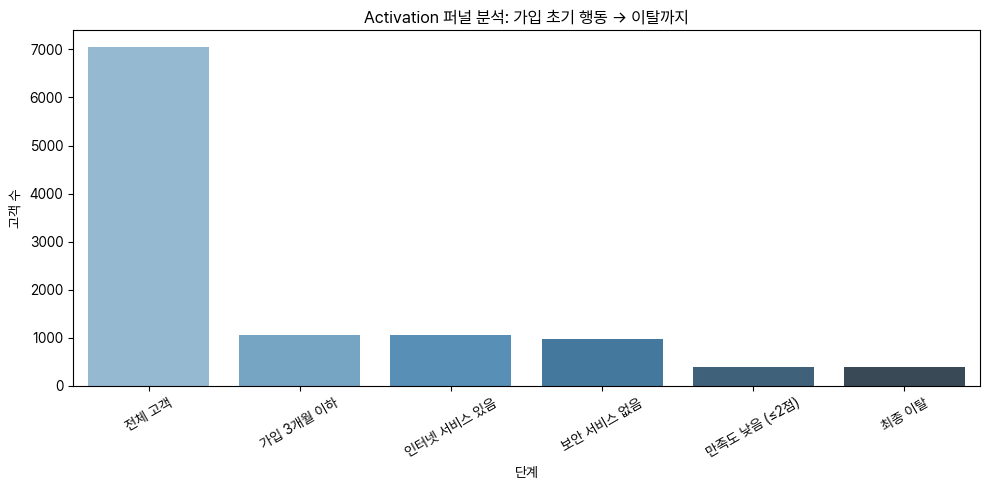

,단계,고객 수
0,전체 고객,7043
1,가입 3개월 이하,1051
2,인터넷 서비스 있음,1051
3,보안 서비스 없음,967
4,만족도 낮음 (≤2점),403
5,최종 이탈,403


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 이탈 여부 이진화
df['ChurnBinary'] = df['Churn Label'].map({'Yes': 1, 'No': 0})

# 퍼널 기준 조건 파생
df['ShortTenure'] = df['Tenure in Months'].apply(lambda x: 1 if x <= 3 else 0)
df['HasInternet'] = df['Internet Service'].apply(lambda x: 1 if x != 'None' else 0)
df['HasSecurity'] = df['Online Security'].apply(lambda x: 1 if x == 'Yes' else 0)
df['LowSatisfaction'] = df['Satisfaction Score'].apply(lambda x: 1 if x <= 2 else 0)

# (1) 전체 고객 수
step_0 = len(df)

# (2) 가입 3개월 이하
df1 = df[df['ShortTenure'] == 1]
step_1 = len(df1)

# (3) 인터넷 서비스 있는 고객
df2 = df1[df1['HasInternet'] == 1]
step_2 = len(df2)

# (4) 보안 서비스 없는 고객
df3 = df2[df2['HasSecurity'] == 0]
step_3 = len(df3)

# (5) 만족도 2점 이하 고객
df4 = df3[df3['LowSatisfaction'] == 1]
step_4 = len(df4)

# (6) 최종 이탈한 고객
step_5 = df4['ChurnBinary'].sum()

# 퍼널 단계 정리
funnel_counts = pd.DataFrame({
    '단계': [
        '전체 고객',
        '가입 3개월 이하',
        '인터넷 서비스 있음',
        '보안 서비스 없음',
        '만족도 낮음 (≤2점)',
        '최종 이탈'
    ],
    '고객 수': [step_0, step_1, step_2, step_3, step_4, step_5]
})

# 시각화
plt.figure(figsize=(10, 5))
sns.barplot(x='단계', y='고객 수', data=funnel_counts, palette='Blues_d')
plt.title('Activation 퍼널 분석: 가입 초기 행동 → 이탈까지')
plt.ylabel('고객 수')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# 퍼널 데이터 확인
display(funnel_counts)

### 3. Retention (잔존 분석)

C:\Users\somee\AppData\Local\Temp\ipykernel_5112\4154176431.py:21: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Pretendard.
  plt.tight_layout()
c:\Users\somee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Pretendard.
  fig.canvas.print_figure(bytes_io, **kw)


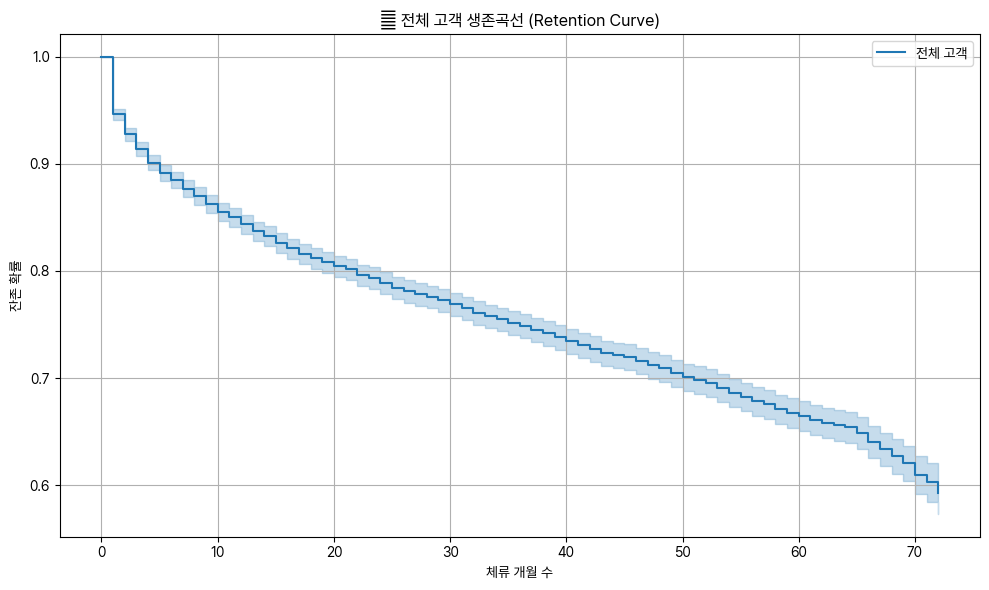

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

df['ChurnBinary'] = df['Churn Label'].map({'Yes': 1, 'No': 0})

# 생존 분석을 위한 준비
T = df['Tenure in Months']        # 생존 기간: 체류 개월 수
E = df['ChurnBinary']             # 이벤트 발생 여부 (1=이탈, 0=잔존)

# ✅ 전체 고객 생존곡선
kmf = KaplanMeierFitter()
kmf.fit(durations=T, event_observed=E, label='전체 고객')

plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title('📈 전체 고객 생존곡선 (Retention Curve)')
plt.xlabel('체류 개월 수')
plt.ylabel('잔존 확률')
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\somee\AppData\Local\Temp\ipykernel_5112\2457223019.py:19: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Pretendard.
  plt.tight_layout()
c:\Users\somee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Pretendard.
  fig.canvas.print_figure(bytes_io, **kw)


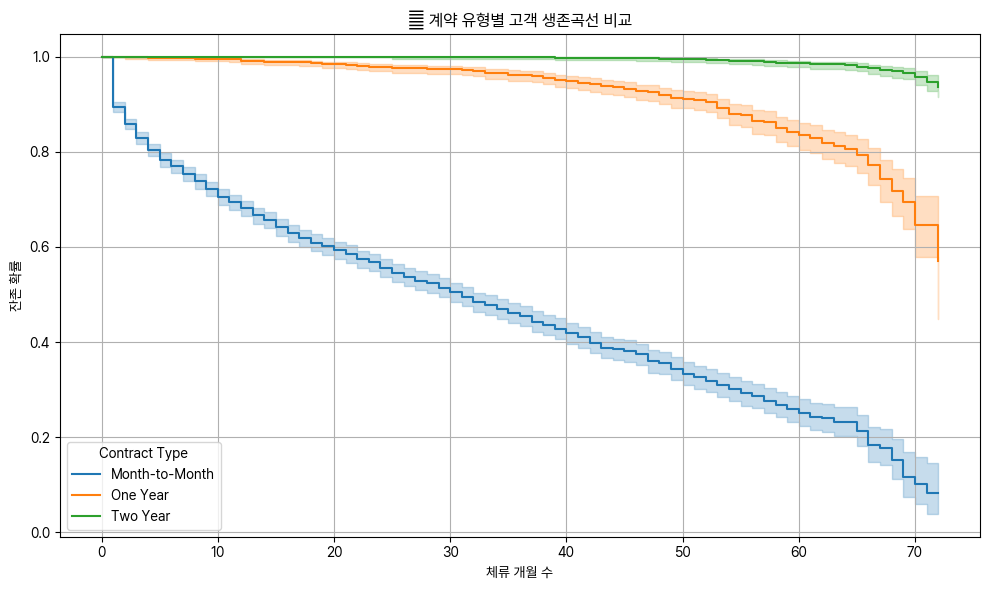

In [22]:
# 계약 유형별 생존곡선 비교
contract_types = df['Contract'].unique()

plt.figure(figsize=(10, 6))

for contract in contract_types:
    subset = df[df['Contract'] == contract]
    T = subset['Tenure in Months']
    E = subset['ChurnBinary']
    
    kmf.fit(T, event_observed=E, label=contract)
    kmf.plot_survival_function()

plt.title('📊 계약 유형별 고객 생존곡선 비교')
plt.xlabel('체류 개월 수')
plt.ylabel('잔존 확률')
plt.legend(title='Contract Type')
plt.grid(True)
plt.tight_layout()
plt.show()

### 4. Revenue (수익 분석)

| 분석 항목           | 활용 컬럼                          |
| --------------- | ------------------------------ |
| 월 납부 요금 구간      | `Monthly Charge`               |
| 고객 생애 가치 (CLTV) | `CLTV`                         |
| 총 수익            | `Total Revenue`                |
| 이탈 여부           | `Churn Label` or `ChurnBinary` |


C:\Users\somee\AppData\Local\Temp\ipykernel_5112\144153134.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  revenue_summary = df.groupby('ChargeGroup').agg(


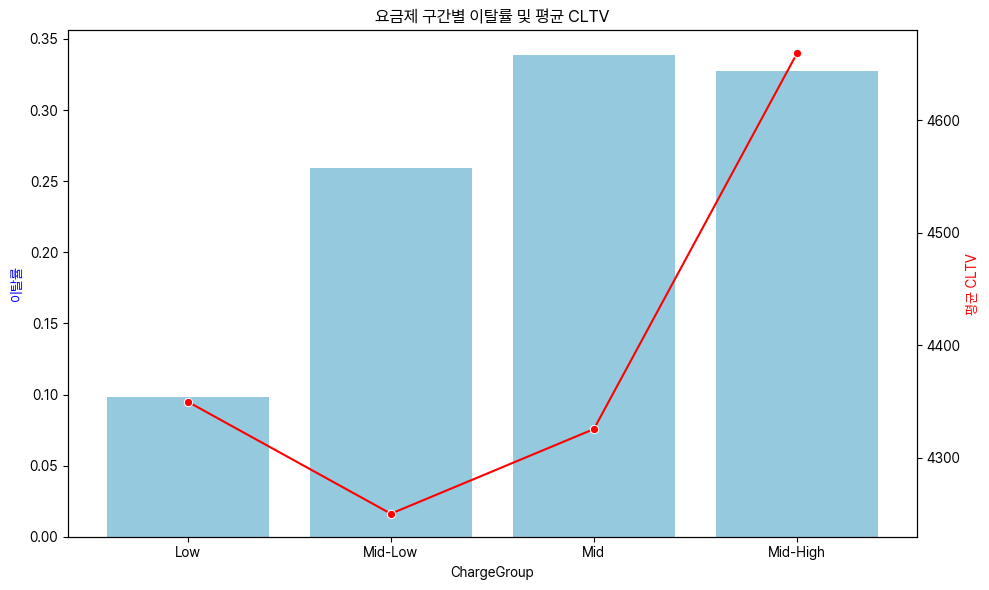

,ChargeGroup,고객수,이탈수,평균_CLTV,평균_수익,이탈률
0,Low,1653,162,4349.935269,1344.928923,0.098004
1,Mid-Low,1265,328,4250.403162,1480.867660,0.259289
2,Mid,2386,809,4325.671836,3038.106572,0.339061
3,Mid-High,1739,570,4659.589994,5765.235371,0.327775
4,High,0,0,NaN,NaN,NaN


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 요금제 구간 나누기
df['ChargeGroup'] = pd.cut(df['Monthly Charge'], 
                           bins=[0, 30, 60, 90, 120, 150], 
                           labels=['Low', 'Mid-Low', 'Mid', 'Mid-High', 'High'])

# 요금제 구간별 이탈률, 평균 CLTV, 평균 수익 계산
revenue_summary = df.groupby('ChargeGroup').agg(
    고객수=('Customer ID', 'count'),
    이탈수=('ChurnBinary', 'sum'),
    평균_CLTV=('CLTV', 'mean'),
    평균_수익=('Total Revenue', 'mean')
).reset_index()
revenue_summary['이탈률'] = revenue_summary['이탈수'] / revenue_summary['고객수']

# 이탈률 + CLTV 이중축 시각화
fig, ax1 = plt.subplots(figsize=(10, 6))

sns.barplot(x='ChargeGroup', y='이탈률', data=revenue_summary, ax=ax1, color='skyblue')
ax1.set_ylabel('이탈률', color='blue')
ax1.set_title('요금제 구간별 이탈률 및 평균 CLTV')

# CLTV는 라인그래프로 추가
ax2 = ax1.twinx()
sns.lineplot(x='ChargeGroup', y='평균_CLTV', data=revenue_summary, ax=ax2, color='red', marker='o')
ax2.set_ylabel('평균 CLTV', color='red')

plt.tight_layout()
plt.show()

# 요약표 확인
display(revenue_summary)

### 5. Referral (추천 분석)

C:\Users\somee\AppData\Local\Temp\ipykernel_5112\1978508491.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='추천 여부', y='이탈률', data=ref_summary, palette='Set2')


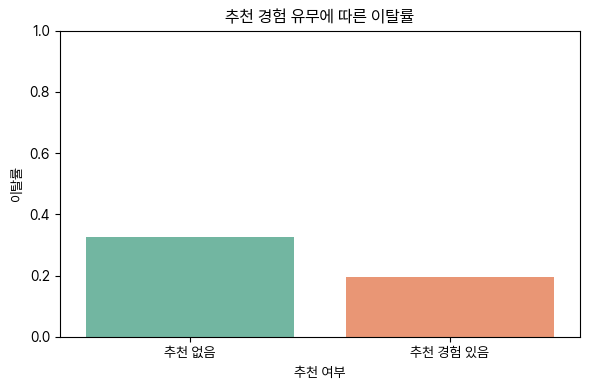

,추천 여부,고객수,이탈수,이탈률
0,추천 없음,3821,1245,0.325831
1,추천 경험 있음,3222,624,0.193669


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 추천 경험 유무 파생
df['IsReferred'] = df['Number of Referrals'].apply(lambda x: 1 if x > 0 else 0)

# 추천 여부별 이탈률
ref_summary = df.groupby('IsReferred').agg(
    고객수=('Customer ID', 'count'),
    이탈수=('ChurnBinary', 'sum')
).reset_index()
ref_summary['이탈률'] = ref_summary['이탈수'] / ref_summary['고객수']
ref_summary['추천 여부'] = ref_summary['IsReferred'].map({1: '추천 경험 있음', 0: '추천 없음'})

# 시각화
plt.figure(figsize=(6, 4))
sns.barplot(x='추천 여부', y='이탈률', data=ref_summary, palette='Set2')
plt.title('추천 경험 유무에 따른 이탈률')
plt.ylabel('이탈률')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

display(ref_summary[['추천 여부', '고객수', '이탈수', '이탈률']])


C:\Users\somee\AppData\Local\Temp\ipykernel_5112\2676256553.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_ref = df.groupby('추천횟수구간').agg(
C:\Users\somee\AppData\Local\Temp\ipykernel_5112\2676256553.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='추천횟수구간', y='이탈률', data=group_ref, palette='coolwarm')


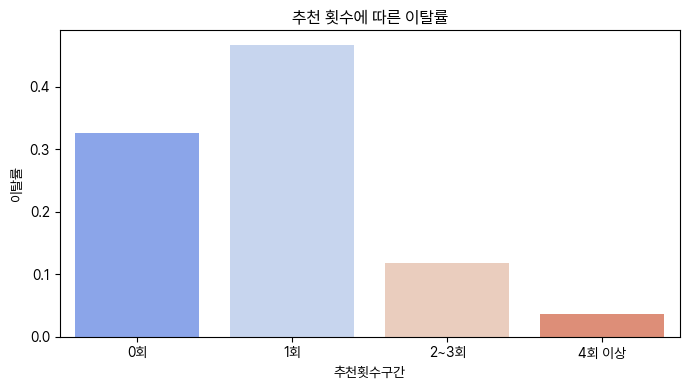

,추천횟수구간,고객수,이탈수,이탈률
0,0회,3821,1245,0.325831
1,1회,1086,507,0.466851
2,2~3회,491,58,0.118126
3,4회 이상,1643,59,0.035910


In [25]:
# 추천 횟수 구간화
df['추천횟수구간'] = pd.cut(df['Number of Referrals'], bins=[-1, 0, 1, 3, 10], 
                           labels=['0회', '1회', '2~3회', '4회 이상'])

# 구간별 이탈률
group_ref = df.groupby('추천횟수구간').agg(
    고객수=('Customer ID', 'count'),
    이탈수=('ChurnBinary', 'sum')
).reset_index()
group_ref['이탈률'] = group_ref['이탈수'] / group_ref['고객수']

# 시각화
plt.figure(figsize=(7, 4))
sns.barplot(x='추천횟수구간', y='이탈률', data=group_ref, palette='coolwarm')
plt.title('추천 횟수에 따른 이탈률')
plt.ylabel('이탈률')
plt.tight_layout()
plt.show()

display(group_ref)

|  번호 | 제목             | 핵심 내용                                                           |
| ------- | -------------- | --------------------------------------------------------------- |
| 1       | 프로젝트 개요        | Telco 고객 이탈 분석 / AARRR 기반 행동 분석                                 |
| 2       | AARRR 프레임 개요   | Acquisition → Activation → Retention → Referral → Revenue 단계 설명 |
| 3       | Acquisition 분석 | 가입 Cohort별 이탈률<br>최근 가입자일수록 이탈률 높음 (2022-12 기준 61%)             |
| 4       | Activation 분석  | 가입 3개월 이하 + 보안 미사용 + 만족도 ≤ 2점 → 전원 이탈 (403명)                    |
| 5       | Retention 분석   | 계약 유형별 생존곡선<br>Month-to-Month 고객 조기 이탈 뚜렷                       |
| 6       | Revenue 분석     | Mid/High 요금제는 수익 높지만 이탈률도 높음 → 리텐션 개입 우선군                       |
| 7       | Referral 분석    | 추천 2회 이상 → 이탈률 급감 (3.5%)<br>추천 1회 고객은 오히려 고위험군                  |
| 8       | 인사이트 요약 & 전략   | 리텐션 개입 타이밍, 추천 기반 충성 유도, 고위험군 행동 흐름 정리                          |


✅ AARRR 단계별 KPI 및 전략 정리표

| AARRR 단계                  | 주요 KPI                               | 현재 수치 (예시)                                     | 전략 제안                              |
| ------------------------- | ------------------------------------ | ---------------------------------------------- | ---------------------------------- |
| **Acquisition**<br>(유입)   | 신규 유입자 수<br>유입 Cohort 이탈률            | 가입자 전원 Q3 / 최근 Cohort 이탈률 62%                  | 초기 온보딩 개선<br>가입 첫 3개월 맞춤 콘텐츠       |
| **Activation**<br>(초기 사용) | 가입 후 7일 내 주요 기능 이용률<br>가입 3개월 이하 이탈률 | 3개월 이하 이탈률 38%<br>만족도≤2점 + 보안X → 100% 이탈       | 해지 UX 중 인터셉트<br>보안 기능 체험 / 쿠폰 제안   |
| **Retention**<br>(지속 사용)  | 체류기간별 생존율<br>계약 유형별 잔존율              | Month-to-Month: 빠른 이탈<br>2-Year: 70개월 생존률 >90% | 계약 만료 전 리마인드<br>사용 급감 고객 실시간 알림    |
| **Referral**<br>(추천)      | 추천 고객 비율<br>추천 경험자 이탈률               | 전체 중 추천자 45.7%<br>이탈률 19.4%                    | 추천 1회 후 만족도 조사<br>추천 ≥4회 고객 VIP 혜택 |
| **Revenue**<br>(수익)       | 요금 구간별 이탈률<br>CLTV / ARPU            | Mid 요금제 이탈률 33.9%<br>Mid-High CLTV 최상          | 고요금 고객 요금 최적화 리포트<br>장기고객 멤버십 리워드  |


🎯 실전 적용 요약
- Acquisition: 가입 시기별 이탈률 차이 → Cohort 기반 타겟팅 필요

- Activation: 만족도 낮고 보안 미이용자 → 이탈 가능성 예측 가능

- Retention: 계약 유형별 생존곡선 → 리텐션 기능 우선순위 설정 가능

- Referral: 추천 ≥2회 → 충성고객 / 추천 1회 → 리스크 신호

- Revenue: 수익 기여도 높은 요금제 이탈 방지 집중


# 리텐션 기능 흐름 시퀀스 다이어그램 설계

목표: 고객의 이탈 전 행동 흐름을 감지하여, 적시에 리텐션 기능이 개입되도록 설계

🧩 예시: Cluster 1 + Activation 기반 이탈 방지 기능 흐름
(가입 초기 + 만족도 낮음 + 보안 미사용 고객)

📌 조건
Tenure ≤ 3개월

Satisfaction Score ≤ 2

Online Security = No

✅ 시퀀스 흐름 요소 정의

| 주체            | 역할                 |
| ------------- | ------------------ |
| 사용자(User)     | 마이페이지 또는 해지 버튼 클릭  |
| 프론트(UI)       | 팝업 노출, 버튼, 쿠폰 창    |
| 백엔드(System)   | 조건 판별, 추천 제안 여부 판단 |
| 알림 서비스(Alert) | 쿠폰 또는 혜택 알림 발송     |

🔁 시퀀스 다이어그램 (텍스트형)

📌 핵심 기능 흐름 정리 (시나리오 요약)

“가입한 지 2개월 된 고객 A는 만족도 점수 2점, 보안 서비스 미이용 상태에서 마이페이지에 접속.
시스템은 이를 감지하고 이탈 징후로 판단하여, 불만족 설문과 함께 보상 쿠폰을 제시하는 팝업을 노출한다.
고객이 이를 수락하고 설문을 제출하면 쿠폰이 발급되고, 앱 푸시로 혜택 메시지가 전송된다.”

# 리텐션 기능 MVP 설계

🎯 기능명
[이탈 징후 고객 인터셉트 + 보상 리마인드 시스템]

### 1. 🧩 대상 조건 (Trigger Logic)

조건:
- Tenure ≤ 3개월
- Satisfaction Score ≤ 2
- Online Security = 'No'
- Churn Score ≥ 70 (선택)

### 2. ⚙️ 주요 기능 흐름

| 단계 | 기능 요소        | 설명                      |
| -- | ------------ | ----------------------- |
| 1  | 실시간 고객 상태 체크 | 고객 페이지 접속 시 백엔드에서 조건 검사 |
| 2  | 인터셉트 팝업 노출   | '설문 + 혜택 제공' 구조         |
| 3  | 설문 응답 수집     | 이탈 원인 라벨링 가능            |
| 4  | 쿠폰 지급 API 호출 | DB 등록 + 메시지 발송 트리거      |
| 5  | 푸시 메시지 전송    | “설문 감사 혜택이 도착했어요!”      |


### 3. 🖥️ UI 구성 (최소 구현)

| 화면    | 요소    | 내용                        |
| ----- | ----- | ------------------------- |
| 팝업창   | 설문 질문 | “서비스가 만족스럽지 않으셨나요?”       |
|       | 선택지   | 요금, 품질, 기능, 기타            |
|       | 보상 내용 | “설문 응답 시 3,000원 할인 쿠폰 제공” |
| 수령 화면 | 확인 버튼 | 쿠폰 코드 노출 또는 자동 적용         |


### 4. 📤 데이터 흐름 요약

### 5. 💡 기대 효과

| 측정 항목     | 기대 변화           |
| --------- | --------------- |
| 가입 초기 이탈률 | -10\~15%p 감소 가능 |
| 설문 회수율    | 30\~50% 예상      |
| 쿠폰 사용률    | 약 20\~30%       |
| 고객 재방문률   | 15% 이상 상승 가능    |


### 6. MVP 개발 시 우선순위 정리

| 우선순위 | 요소             | 이유                   |
| ---- | -------------- | -------------------- |
| ✅ 1  | 조건 체크 & 팝업 트리거 | 이탈 조건이 가장 강력한 개입 타이밍 |
| ✅ 2  | 설문 응답 저장       | 이후 서비스 개선 및 NPS 추적   |
| ✅ 3  | 쿠폰 발급 기능       | 리워드 제공 통한 행동 유도      |
| ✅ 4  | 메시지 연동         | 리마인드 효과 증가           |


## ✅ QA 테스트 시나리오: 리텐션 기능 (가입 초기 이탈 방지)

| Test Case ID  | 시나리오 설명                 | 테스트 조건 (입력값)                         | 기대 결과              | 비고                |
| ------------- | ----------------------- | ------------------------------------ | ------------------ | ----------------- |
| **QA-R1-001** | 조건 만족 고객에게 팝업이 노출되는가    | Tenure=2, Satis=2, OnlineSecurity=No | “설문 + 혜택 제안 팝업” 노출 | 접속 즉시 UI 확인 필요    |
| **QA-R1-002** | 조건 미충족 고객에겐 팝업이 뜨지 않는가  | Tenure=6, Satis=4                    | 팝업 없음              | false positive 방지 |
| **QA-R1-003** | 설문 응답 후 응답 내용이 저장되는가    | 응답: “요금이 비쌈”                         | DB 저장됨, 서버 응답 200  | 로그 확인             |
| **QA-R1-004** | 설문 완료 시 쿠폰이 생성되는가       | 응답 후 수령 클릭                           | 쿠폰 코드 발급, 상태 "미사용" | DB 쿠폰 테이블 확인      |
| **QA-R1-005** | 쿠폰 발급 시 알림 메시지가 전송되는가   | 푸시 설정 ON                             | “혜택 도착” 푸시 메시지 수신  | 푸시 로그 확인          |
| **QA-R1-006** | 동일 고객에게 반복 팝업이 노출되지 않는가 | 설문 제출 완료 후 재접속                       | 팝업 미노출             | 상태값 체크 필요         |


### 🛠 테스트 범주 정리
✅ 조건부 UI 트리거 확인

✅ 응답 → DB 저장 기능

✅ 쿠폰 발급 기능 정상 여부

✅ 알림 연동 (푸시 메시지)

✅ 중복 방지 로직



### 🎯 테스트 팁 (실무 기준)
조건부 로직 테스트는 최소 2명 이상의 더미 계정 필요
(조건 만족 / 조건 불만족 고객 구분)

설문 응답별 전환율 비교 분석을 QA 이후 데이터 분석팀과 연계 가능



## 리텐션 중심 KPI 설계

| 카테고리           | KPI 지표명         | 정의                      | 측정 주기 | 목표 기준 | 관련 기능            |
| -------------- | --------------- | ----------------------- | ----- | ----- | ---------------- |
| **Activation** | 초기 이탈률          | 가입 후 3개월 이내 이탈률         | 주간/월간 | ≤ 20% | 인터셉트 팝업, 쿠폰 리마인드 |
|                | 만족도 낮은 고객 비율    | Satisfaction ≤ 2 비율     | 월간    | ≤ 10% | 설문 수집, 개선 피드백    |
| **Retention**  | 장기 고객 비율        | Tenure ≥ 12개월 비율        | 월간    | ≥ 50% | VIP 리워드, 혜택 누적   |
|                | 해지 직전 개입 전환율    | 팝업 클릭 후 이탈 막은 비율        | 주간    | ≥ 30% | 해지 UX 인터셉트       |
| **Referral**   | 추천 고객 비율        | Number of Referrals ≥ 1 | 월간    | ≥ 60% | 추천 리워드, 친구 초대    |
|                | 추천 4회 이상 고객 이탈률 | 해당 고객군 이탈률              | 분기    | ≤ 5%  | VIP 등급 유지        |
| **Revenue**    | CLTV 상위 30% 이탈률 | 고가치 고객 이탈률              | 월간    | ≤ 10% | 멤버십 브리핑, 맞춤 혜택   |
|                | 요금제 전환율         | 고요금 → 최적 요금제 전환률        | 분기    | ≥ 20% | 요금 최적화 리포트       |
| **Engagement** | 설문 응답률          | 팝업 응답 수 / 노출 수          | 주간    | ≥ 40% | 만족도 설문 팝업        |
|                | 쿠폰 사용률          | 발급 대비 실제 사용률            | 주간    | ≥ 25% | 알림 연동, 혜택 상세뷰    |